# 第6章: 機械学習

本章では，Fabio Gasparetti氏が公開している[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)を用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

## 50. データの入手・整形
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
3. 抽出された事例をランダムに並び替える．
4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [1]:
import itertools
import json
import numpy as np
import operator
import os
import pandas as pd
import pickle

In [2]:
input_path = os.path.join(os.getcwd(), '../data/newsCorpora.csv')

In [3]:
# 読み込み
df = pd.read_csv(input_path, sep='\t', names=('ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'))
df.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [4]:
# データ数、データ型
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422419 entries, 0 to 422418
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ID         422419 non-null  int64 
 1   TITLE      422419 non-null  object
 2   URL        422419 non-null  object
 3   PUBLISHER  422417 non-null  object
 4   CATEGORY   422419 non-null  object
 5   STORY      422419 non-null  object
 6   HOSTNAME   422419 non-null  object
 7   TIMESTAMP  422419 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 25.8+ MB


In [5]:
# 欠損
df.isnull().sum()

ID           0
TITLE        0
URL          0
PUBLISHER    2
CATEGORY     0
STORY        0
HOSTNAME     0
TIMESTAMP    0
dtype: int64

In [6]:
# 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
df = df[df['PUBLISHER'].apply(lambda x: x in ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail'])]
df.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
12,13,Europe reaches crunch point on banking union,http://in.reuters.com/article/2014/03/10/eu-ba...,Reuters,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,in.reuters.com,1394470501755
13,14,ECB FOCUS-Stronger euro drowns out ECB's messa...,http://in.reuters.com/article/2014/03/10/ecb-p...,Reuters,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,in.reuters.com,1394470501948
19,20,"Euro Anxieties Wane as Bunds Top Treasuries, S...",http://www.businessweek.com/news/2014-03-10/ge...,Businessweek,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,www.businessweek.com,1394470503148
20,21,Noyer Says Strong Euro Creates Unwarranted Eco...,http://www.businessweek.com/news/2014-03-10/no...,Businessweek,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,www.businessweek.com,1394470503366
29,30,REFILE-Bad loan triggers key feature in ECB ba...,http://in.reuters.com/article/2014/03/10/euroz...,Reuters,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,in.reuters.com,1394470505070


In [7]:
# データ数、データ型
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13340 entries, 12 to 422319
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         13340 non-null  int64 
 1   TITLE      13340 non-null  object
 2   URL        13340 non-null  object
 3   PUBLISHER  13340 non-null  object
 4   CATEGORY   13340 non-null  object
 5   STORY      13340 non-null  object
 6   HOSTNAME   13340 non-null  object
 7   TIMESTAMP  13340 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 938.0+ KB


In [8]:
# CATEGORYごとの数
df.groupby('CATEGORY').count()

,ID,TITLE,URL,PUBLISHER,STORY,HOSTNAME,TIMESTAMP
CATEGORY,,,,,,,
b,5627,5627,5627,5627,5627,5627,5627
e,5279,5279,5279,5279,5279,5279,5279
m,910,910,910,910,910,910,910
t,1524,1524,1524,1524,1524,1524,1524


In [9]:
# PUBLISHERごとの数
df.groupby('PUBLISHER').count()

,ID,TITLE,URL,CATEGORY,STORY,HOSTNAME,TIMESTAMP
PUBLISHER,,,,,,,
Businessweek,2395,2395,2395,2395,2395,2395,2395
Contactmusic.com,2334,2334,2334,2334,2334,2334,2334
Daily Mail,2254,2254,2254,2254,2254,2254,2254
Huffington Post,2455,2455,2455,2455,2455,2455,2455
Reuters,3902,3902,3902,3902,3902,3902,3902


In [10]:
# 抽出された事例をランダムに並び替える
df = df.sample(frac=1.0, random_state=0).reset_index(drop=True)
df.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,311098,RPT-Fitch Updates EMEA Consumer ABS Rating Cri...,http://in.reuters.com/article/2014/06/24/fitch...,Reuters,b,d3tIMfB2mg-9MZM4G_jGTEiRVl3jM,in.reuters.com,1403633888597
1,49198,"Gurlitt Wants to Return Nazi-Looted Art, Suedd...",http://www.businessweek.com/news/2014-03-26/gu...,Businessweek,e,dWeC4g3bvX-bI6MKAcxt43Jp7MzSM,www.businessweek.com,1395886231417
2,410578,"UPDATE 1-Fairfax Financial, CEO probed over po...",http://in.reuters.com/article/2014/08/01/fairf...,Reuters,b,d6s61cXf9rASExMO8inpkRujc9VTM,in.reuters.com,1406929609070
3,270668,Angelina Jolie - Angelina Jolie Will Not Tight...,http://www.contactmusic.com/story/angelina-jol...,Contactmusic.com,e,d7SbUKanRaD34YMwE64lo09d_qCnM,www.contactmusic.com,1401828902205
4,301656,Patent Officials Cancel the Washington Redskin...,http://www.businessweek.com/articles/2014-06-1...,Businessweek,b,dXVU3KhKpHSxleMNmc46pQj6e5zwM,www.businessweek.com,1403113194649


In [11]:
len(df)

13340

In [12]:
# 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割
train_num = int(len(df) * 0.8)
valid_num = int(len(df) * 0.1)
df_train = df[0:train_num]
df_valid = df[train_num:train_num + valid_num]
df_test = df[train_num + valid_num:]

In [13]:
# 数確認
len(df_train) + len(df_valid) + len(df_test)

13340

In [14]:
# それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する
# １行に１事例を書き出す
# カテゴリ名と記事見出しのタブ区切り形式
df_train[['CATEGORY', 'TITLE']].to_csv('train.txt', sep='\t', index=False)
df_valid[['CATEGORY', 'TITLE']].to_csv('valid.txt', sep='\t', index=False)
df_test[['CATEGORY', 'TITLE']].to_csv('test.txt', sep='\t', index=False)

In [15]:
# カテゴリごとのデータ数
# 訓練データ
df_train.groupby('CATEGORY').count()

,ID,TITLE,URL,PUBLISHER,STORY,HOSTNAME,TIMESTAMP
CATEGORY,,,,,,,
b,4493,4493,4493,4493,4493,4493,4493
e,4232,4232,4232,4232,4232,4232,4232
m,717,717,717,717,717,717,717
t,1230,1230,1230,1230,1230,1230,1230


In [16]:
# カテゴリごとのデータ数
# 評価データ
df_test.groupby('CATEGORY').count()

,ID,TITLE,URL,PUBLISHER,STORY,HOSTNAME,TIMESTAMP
CATEGORY,,,,,,,
b,564,564,564,564,564,564,564
e,517,517,517,517,517,517,517
m,96,96,96,96,96,96,96
t,157,157,157,157,157,157,157


## 51. 特徴量抽出

学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ．
なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [7]:
# tf-idf変換準備
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
# 試しに動かす
tf_vec = TfidfVectorizer()

tes = pd.DataFrame([
    'This is my car',
    'This is my friend',
    'This is my English book',
], columns=['TITLE'])

tes_vector = tf_vec.fit_transform(tes['TITLE'].tolist())

print(tf_vec.get_feature_names())
print(tes_vector.toarray())

['book', 'car', 'english', 'friend', 'is', 'my', 'this']
[[0.         0.69903033 0.         0.         0.41285857 0.41285857
  0.41285857]
 [0.         0.         0.         0.69903033 0.41285857 0.41285857
  0.41285857]
 [0.57292883 0.         0.57292883 0.         0.338381   0.338381
  0.338381  ]]


In [9]:
# 学習データ，検証データ，評価データ読み込み
df_train = pd.read_csv('train.txt', sep='\t')
df_valid = pd.read_csv('valid.txt', sep='\t')
df_test = pd.read_csv('test.txt', sep='\t')
df_test.head()

,CATEGORY,TITLE
0,b,Vodafone's Service Revenue Falls as European M...
1,e,"So, Tupac Shakur's Final Words Were A Big ""F*C..."
2,t,Elephants really are intelligent: Creatures ca...
3,t,FTC says Snapchat deceived customers over 'dis...
4,b,UPDATE 3-GM says facing multiple probes into r...


In [10]:
# tf-idf変換
tf_vec = TfidfVectorizer()
# 計算 & 変換
train_data = tf_vec.fit_transform(df_train['TITLE'].tolist()).toarray()
feature_names = tf_vec.get_feature_names()
# 変換
valid_data = tf_vec.transform(df_valid['TITLE'].tolist()).toarray()
test_data = tf_vec.transform(df_test['TITLE'].tolist()).toarray()

In [21]:
train = {
    'data': train_data.tolist(),
    'target': df_train['CATEGORY'].tolist()
}
valid = {
    'data': valid_data.tolist(),
    'target': df_valid['CATEGORY'].tolist()
}
test = {
    'data': test_data.tolist(),
    'target': df_test['CATEGORY'].tolist()
}

In [22]:
# 辞書をJSONに変換して保存
def save_dict_json(save_dict: dict, file_name: str):
    text = json.dumps(save_dict)
    with open(file_name, mode='w') as f:
        f.write(text)

save_dict_json(save_dict={'a': ['b', 'c']}, file_name='tes.txt')

In [23]:
# 保存
save_dict_json(save_dict=train, file_name='train.feature.txt')
save_dict_json(save_dict=valid, file_name='valid.feature.txt')
save_dict_json(save_dict=test, file_name='test.feature.txt')

## 52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [2]:
# JSONを読み込んで辞書に変換
def load_json_dict(file_name: str):
    with open(file_name, mode='r') as f:
        text = f.read()    
    return json.loads(text)

load_json_dict(file_name='tes.txt')

{'a': ['b', 'c']}

In [3]:
train = load_json_dict(file_name='train.feature.txt')
test = load_json_dict(file_name='test.feature.txt')
valid = load_json_dict(file_name='valid.feature.txt')

In [4]:
from sklearn.linear_model import LogisticRegression

In [5]:
X = train['data']
y = train['target']
clf = LogisticRegression(random_state=0).fit(X, y)

C:\Users\kazuy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## 53. 予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [11]:
# 文字列入れると、予測カテゴリと予測確率を返す
def get_score(text):
    X = tf_vec.transform([text])
    return (clf.predict(X), clf.predict_proba(X))

get_score('This is a pen')

(array(['e'], dtype='<U1'),
 array([[0.14747156, 0.57247087, 0.09697171, 0.18308586]]))

## 54. 正解率の計測
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [12]:
# 学習データ
X = train['data']
y = train['target']
clf.score(X, y)

0.9446214392803598

In [15]:
# 評価データ
X = test['data']
y = test['target']
clf.score(X, y)

0.889055472263868

# 55. 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [16]:
from sklearn.metrics import confusion_matrix

In [17]:
# 学習データ
y_true = train['target']
X = train['data']
y_pred = clf.predict(X)
confusion_matrix(y_true, y_pred)

array([[4404,   58,    4,   27],
       [  23, 4204,    0,    5],
       [  73,  133,  507,    4],
       [ 151,  111,    2,  966]], dtype=int64)

In [18]:
# 評価データ
y_true = test['target']
X = test['data']
y_pred = clf.predict(X)
confusion_matrix(y_true, y_pred)

array([[530,  16,   1,  17],
       [  4, 512,   0,   1],
       [ 22,  26,  48,   0],
       [ 38,  22,   1,  96]], dtype=int64)

## 56. 適合率，再現率，F1スコアの計測
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support, classification_report

In [20]:
# 評価データ
y_true = test['target']
X = test['data']
y_pred = clf.predict(X)

In [21]:
# カテゴリごとの適合率
precision_score(y_true, y_pred, average=None)

array([0.89225589, 0.88888889, 0.96      , 0.84210526])

In [22]:
# カテゴリごとの再現率
recall_score(y_true, y_pred, average=None)

array([0.93971631, 0.99032882, 0.5       , 0.61146497])

In [23]:
# カテゴリごとのF1スコア
f1_score(y_true, y_pred, average=None)

array([0.91537133, 0.936871  , 0.65753425, 0.70848708])

In [24]:
# 適合率、再現率、F1スコア一気に出す
precision_recall_fscore_support(y_true, y_pred, average=None)

(array([0.89225589, 0.88888889, 0.96      , 0.84210526]),
 array([0.93971631, 0.99032882, 0.5       , 0.61146497]),
 array([0.91537133, 0.936871  , 0.65753425, 0.70848708]),
 array([564, 517,  96, 157], dtype=int64))

In [25]:
# マイクロ平均
# 「サンプルに無い分類」とかがなければ、全体の正解率に一致する
precision_recall_fscore_support(y_true, y_pred, average='micro')

(0.889055472263868, 0.889055472263868, 0.8890554722638679, None)

In [26]:
# マクロ平均
# カテゴリごとに適合率、再現率、F1スコアを出して、それを平均したもの
# 絶対数が少ないクラスの影響を受けやすい。全クラスを平等に扱いたかったらコレ
precision_recall_fscore_support(y_true, y_pred, average='macro')

(0.895812511075669, 0.7603775250814144, 0.8045659146451385, None)

In [27]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           b       0.89      0.94      0.92       564
           e       0.89      0.99      0.94       517
           m       0.96      0.50      0.66        96
           t       0.84      0.61      0.71       157

    accuracy                           0.89      1334
   macro avg       0.90      0.76      0.80      1334
weighted avg       0.89      0.89      0.88      1334



## 57. 特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [28]:
# 係数
clf.coef_

array([[ 0.20719803, -0.0041297 ,  0.07722516, ..., -0.07351441,
        -0.05707517, -0.01206088],
       [-0.14106151,  0.00838221, -0.04981281, ...,  0.12753155,
         0.10518314,  0.03171352],
       [-0.02750033, -0.00147606, -0.01269625, ..., -0.02023845,
        -0.02115569, -0.00813332],
       [-0.03863619, -0.00277645, -0.0147161 , ..., -0.03377868,
        -0.02695228, -0.01151933]])

In [29]:
# 4分類のそれぞれ、係数設定されている
clf.coef_.shape

(4, 12881)

In [30]:
# 係数の名前
len(feature_names)

12881

In [31]:
# いくつか見てみる
feature_names[-25:]

['zebras',
 'zendaya',
 'zeppelin',
 'zero',
 'zeus',
 'zew',
 'ziering',
 'ziff',
 'zillow',
 'zions',
 'zip',
 'zloty',
 'zmapp',
 'zoe',
 'zombie',
 'zombies',
 'zone',
 'zoosk',
 'zpfa3mqti7qdrpfhqwjm',
 'zuckerberg',
 'zynga',
 'zâ',
 'œf',
 'œlousyâ',
 'œwaist']

In [32]:
# {名前: 係数の重み}の辞書
# 全体の重みとしては全カテゴリの係数のL2ノルムを取る
feature_dict = [
    {
        'name': f,
        'l2': np.linalg.norm(w, ord=2),
        'b': w[0],
        'e': w[1],
        'm': w[2],
        't': w[3],
    }
    for f, w in zip(feature_names, clf.coef_.T)
]

In [33]:
# 重みの大きい特徴量トップ10
sorted(feature_dict, key=operator.itemgetter('l2'), reverse=True)[:10]

[{'name': 'google',
  'l2': 6.6941316552036065,
  'b': -1.8597138967102924,
  'e': -2.880657104134208,
  'm': -0.9327767212175263,
  't': 5.673147722062012},
 {'name': 'facebook',
  'l2': 5.919647492318737,
  'b': -1.7954045155417653,
  'e': -2.2122345655051787,
  'm': -1.0697924864006052,
  't': 5.07743156744753},
 {'name': 'apple',
  'l2': 5.460688779492947,
  'b': -1.6752679419843468,
  'e': -2.03721326923247,
  'm': -0.969631206141402,
  't': 4.6821124173581765},
 {'name': 'ebola',
  'l2': 5.35177056311247,
  'b': -2.0309615074461203,
  'e': -1.6596464400937074,
  'm': 4.579524493235332,
  't': -0.888916545695549},
 {'name': 'microsoft',
  'l2': 4.758723945539696,
  'b': -1.6017309768065562,
  'e': -1.8074467391802214,
  'm': -0.6408110442863435,
  't': 4.049988760273124},
 {'name': 'study',
  'l2': 4.624390059490769,
  'b': -1.6210823606781717,
  'e': -2.1681574890207926,
  'm': 3.7489390971799703,
  't': 0.04030075251904377},
 {'name': 'update',
  'l2': 4.470272842022317,
  'b': 

In [34]:
# 重みの低い特徴量トップ10
sorted(feature_dict, key=operator.itemgetter('l2'))[:10]

[{'name': 'narrowed',
  'l2': 0.0027192291364949977,
  'b': -0.0009745231174012175,
  'e': 0.002345704532723655,
  'm': -0.0006530884099673147,
  't': -0.0007180930053551612},
 {'name': 'upstage',
  'l2': 0.002829619129680863,
  'b': -0.0010457101500956905,
  'e': 0.002437620535130988,
  'm': -0.0007315471000660146,
  't': -0.0006603632849693084},
 {'name': '1201178058',
  'l2': 0.003286391515352574,
  'b': -0.0013765676390545716,
  'e': 0.0027940702770483782,
  'm': -0.0004920197455653824,
  't': -0.0009254828924284263},
 {'name': '1399983366398',
  'l2': 0.003286391515352574,
  'b': -0.0013765676390545716,
  'e': 0.0027940702770483782,
  'm': -0.0004920197455653824,
  't': -0.0009254828924284263},
 {'name': '1399983366584',
  'l2': 0.003286391515352574,
  'b': -0.0013765676390545716,
  'e': 0.0027940702770483782,
  'm': -0.0004920197455653824,
  't': -0.0009254828924284263},
 {'name': '1399983366926',
  'l2': 0.003286391515352574,
  'b': -0.0013765676390545716,
  'e': 0.0027940702770

In [35]:
# b = businessに影響が大きい特徴量トップ10
sorted(feature_dict, key=operator.itemgetter('b'), reverse=True)[:5]

[{'name': 'fed',
  'l2': 3.9970509419533373,
  'b': 3.4253710680574208,
  'e': -1.5333668973932124,
  'm': -0.7199541415695101,
  't': -1.1720500290946838},
 {'name': 'bank',
  'l2': 4.013477835231574,
  'b': 3.410257945929046,
  'e': -1.7699231726479996,
  'm': -0.8110034674721136,
  't': -0.8293313058089478},
 {'name': 'stocks',
  'l2': 3.667410266519026,
  'b': 3.101652417143734,
  'e': -1.23093026926733,
  'm': -0.4040135694181027,
  't': -1.4667085784582725},
 {'name': 'ecb',
  'l2': 3.54550233343144,
  'b': 3.030270985211868,
  'e': -1.4355236531489948,
  'm': -0.6304801861710382,
  't': -0.9642671458918326},
 {'name': 'china',
  'l2': 3.8600602874024488,
  'b': 2.986558808198245,
  'e': -2.3528369240929567,
  'm': -0.6660661846985496,
  't': 0.0323443005932857}]

In [36]:
# e = entertainmentに影響が大きい特徴量トップ10
sorted(feature_dict, key=operator.itemgetter('e'), reverse=True)[:5]

[{'name': 'kardashian',
  'l2': 3.789134670627228,
  'b': -1.599611157515646,
  'e': 3.2313141233837817,
  'm': -0.7014673745320484,
  't': -0.9302355913360786},
 {'name': 'her',
  'l2': 3.465303396265054,
  'b': -1.8101941225653557,
  'e': 2.757048951691345,
  'm': 0.11049848444045533,
  't': -1.057353313566463},
 {'name': 'chris',
  'l2': 3.1748666061667548,
  'b': -1.3262922198838691,
  'e': 2.7112721111260067,
  'm': -0.6195317237192292,
  't': -0.7654481675228787},
 {'name': 'kim',
  'l2': 3.0365754039095147,
  'b': -1.2680913059421846,
  'e': 2.5913361534242596,
  'm': -0.5562110861523234,
  't': -0.767033761329768},
 {'name': 'she',
  'l2': 3.228909118600914,
  'b': -1.8668533599246904,
  'e': 2.5296251609398634,
  'm': 0.06990946686631526,
  't': -0.7326812678815137}]

In [37]:
# m = healthに影響が大きい特徴量トップ10
sorted(feature_dict, key=operator.itemgetter('m'), reverse=True)[:5]

[{'name': 'ebola',
  'l2': 5.35177056311247,
  'b': -2.0309615074461203,
  'e': -1.6596464400937074,
  'm': 4.579524493235332,
  't': -0.888916545695549},
 {'name': 'study',
  'l2': 4.624390059490769,
  'b': -1.6210823606781717,
  'e': -2.1681574890207926,
  'm': 3.7489390971799703,
  't': 0.04030075251904377},
 {'name': 'fda',
  'l2': 4.212363550885448,
  'b': -1.5151770774104083,
  'e': -1.2769642402345691,
  'm': 3.6231293546397243,
  't': -0.8309880369947558},
 {'name': 'cancer',
  'l2': 4.113824416131823,
  'b': -0.9979974271594815,
  'e': -1.545781180042767,
  'm': 3.5415487719290386,
  't': -0.9977701647267796},
 {'name': 'mers',
  'l2': 3.957172059859735,
  'b': -1.4574811155155878,
  'e': -1.2317049382355767,
  'm': 3.394227340421683,
  't': -0.7050412866705165}]

In [38]:
# t = science and technologyに影響が大きい特徴量トップ10
sorted(feature_dict, key=operator.itemgetter('t'), reverse=True)[:5]

[{'name': 'google',
  'l2': 6.6941316552036065,
  'b': -1.8597138967102924,
  'e': -2.880657104134208,
  'm': -0.9327767212175263,
  't': 5.673147722062012},
 {'name': 'facebook',
  'l2': 5.919647492318737,
  'b': -1.7954045155417653,
  'e': -2.2122345655051787,
  'm': -1.0697924864006052,
  't': 5.07743156744753},
 {'name': 'apple',
  'l2': 5.460688779492947,
  'b': -1.6752679419843468,
  'e': -2.03721326923247,
  'm': -0.969631206141402,
  't': 4.6821124173581765},
 {'name': 'microsoft',
  'l2': 4.758723945539696,
  'b': -1.6017309768065562,
  'e': -1.8074467391802214,
  'm': -0.6408110442863435,
  't': 4.049988760273124},
 {'name': 'climate',
  'l2': 4.414851653311244,
  'b': -1.193814414494229,
  'e': -1.7571962647663604,
  'm': -0.8292453558926476,
  't': 3.7802560351532346}]

## 58. 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [43]:
import matplotlib.pyplot as plt

In [44]:
params = [0.1, 0.5, 1.0, 2.5, 5.0, 7.5, 10.0]

In [45]:
x = []
y_train = []
y_test = []
y_valid = []
for p in params:
    print(p)
    # 横軸 = 正則化パラメータ
    x.append(p)
    # パラメータ設定して学習
    clf = LogisticRegression(C=p, random_state=0).fit(train['data'], train['target'])
    # 縦軸 = 正解率
    y_train.append(clf.score(train['data'], train['target']))
    y_test.append(clf.score(test['data'], test['target']))
    y_valid.append(clf.score(valid['data'], valid['target'])) 

0.1
0.5
1.0


C:\Users\kazuy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


2.5


C:\Users\kazuy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


5.0


C:\Users\kazuy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


7.5


C:\Users\kazuy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


10.0


C:\Users\kazuy\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [46]:
tes = {
    'train': {'x': x, 'y': y_train},
    'test': {'x': x, 'y': y_test},
    'valid': {'x': x, 'y': y_valid},
}

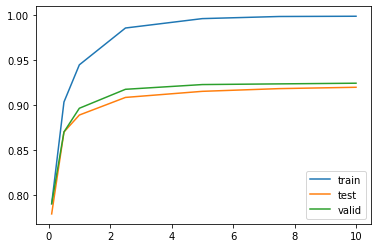

In [47]:
fig, ax = plt.subplots()

for k in ['train', 'test', 'valid']:
    ax.plot(tes[k]['x'], tes[k]['y'], label=k)
ax.legend()

## 59. ハイパーパラメータの探索
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [48]:
# パラメータ
solver_list = ['lbfgs', 'newton-cg', 'sag', 'saga']
C_list = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

In [49]:
results = []
for solver, C in itertools.product(solver_list, C_list):
    print(solver, C)
    # モデル
    model = LogisticRegression(
        solver=solver,
        C=C,
        multi_class='multinomial',
        warm_start=True,
        max_iter=1000,
        random_state=0
    )
    # 学習
    model.fit(train['data'], train['target'])
    # 検証データ上の正解率
    score = model.score(valid['data'], valid['target'])
    # 結果保存
    results.append({
        'solver': solver,
        'C': C,
        'valid_score': score,
        'model': model,
    })

lbfgs 1.0
lbfgs 2.0
lbfgs 3.0
lbfgs 4.0
lbfgs 5.0
lbfgs 6.0
lbfgs 7.0
lbfgs 8.0
lbfgs 9.0
lbfgs 10.0
newton-cg 1.0
newton-cg 2.0
newton-cg 3.0
newton-cg 4.0
newton-cg 5.0
newton-cg 6.0
newton-cg 7.0
newton-cg 8.0
newton-cg 9.0
newton-cg 10.0
sag 1.0
sag 2.0
sag 3.0
sag 4.0
sag 5.0
sag 6.0
sag 7.0
sag 8.0
sag 9.0
sag 10.0
saga 1.0
saga 2.0
saga 3.0
saga 4.0
saga 5.0
saga 6.0
saga 7.0
saga 8.0
saga 9.0
saga 10.0


In [50]:
# 保存
results_path = os.path.join(os.getcwd(), '../model/59_results.pickle')
with open(results_path, mode="wb") as f:
    pickle.dump(results, f)

In [51]:
# 保存ファイル読み込み
with open(results_path, mode="rb") as f:
    results = pickle.load(f)

In [52]:
results

[{'solver': 'lbfgs',
  'C': 1.0,
  'valid_score': 0.896551724137931,
  'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=1000,
                     multi_class='multinomial', n_jobs=None, penalty='l2',
                     random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=True)},
 {'solver': 'lbfgs',
  'C': 2.0,
  'valid_score': 0.9115442278860569,
  'model': LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=1000,
                     multi_class='multinomial', n_jobs=None, penalty='l2',
                     random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=True)},
 {'solver': 'lbfgs',
  'C': 3.0,
  'valid_score': 0.9182908545727136,
  'model': LogisticRegression(C=3.0, class_weight=None, dual=False, fit_intercept=True,
 

In [53]:
# test_scoreが大きい順TOP5
sorted(results, key=operator.itemgetter('valid_score'), reverse=True)[:5]

[{'solver': 'lbfgs',
  'C': 10.0,
  'valid_score': 0.9265367316341829,
  'model': LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=1000,
                     multi_class='multinomial', n_jobs=None, penalty='l2',
                     random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=True)},
 {'solver': 'newton-cg',
  'C': 10.0,
  'valid_score': 0.9265367316341829,
  'model': LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=1000,
                     multi_class='multinomial', n_jobs=None, penalty='l2',
                     random_state=0, solver='newton-cg', tol=0.0001, verbose=0,
                     warm_start=True)},
 {'solver': 'sag',
  'C': 10.0,
  'valid_score': 0.9265367316341829,
  'model': LogisticRegression(C=10.0, class_weight=None, dual=False, fit_inte

In [54]:
# 正解率が最も高くなる学習アルゴリズム・パラメータ
best_model = sorted(results, key=operator.itemgetter('valid_score'), reverse=True)[0]['model']
best_model

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=True)

In [55]:
# 評価データ上の正解率
best_model.score(test['data'], test['target'])

0.9190404797601199